3-Phase state space inverter:

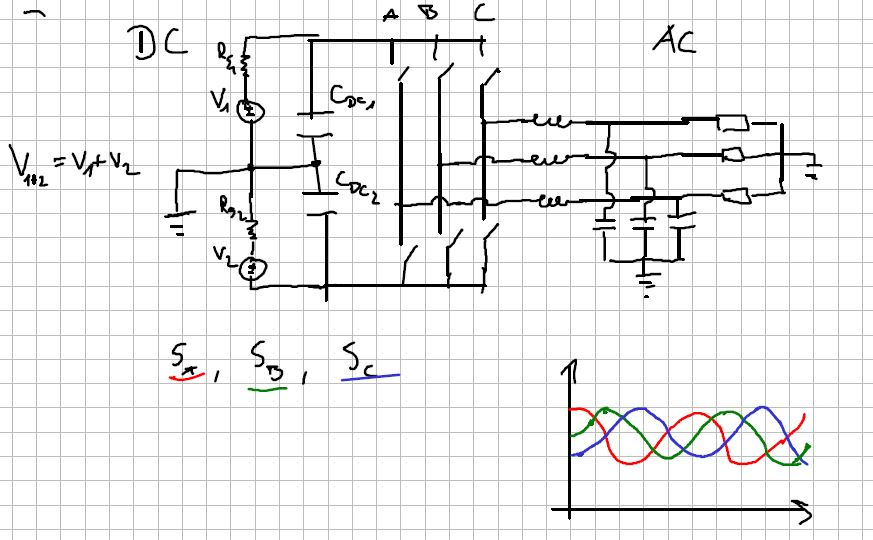

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from pymgrit.core.application import Application
from pymgrit.core.vector import Vector
from pymgrit.core.simple_setup_problem import simple_setup_problem

from mpi4py import MPI
from pymgrit.core.mgrit import Mgrit

import pathlib
from random import randrange

C:\Users\ssahi\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ssahi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\ssahi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [53]:
class VectorStateSpaceInverter(Vector):
    """
    Vector for the Substitue Inverter model
    """

    def __init__(self):
        super().__init__()
        # Values of V,I at the nodes
        
        self.Vcdc1 = 0
        self.Vcdc2 = 0
        self.Il1   = 0
        self.Vc1   = 0
        self.i   = 0

    def set_values(self, value):
        self.Vcdc1 = value[0]
        self.Vcdc2 = value[1]
        self.Il1   = value[2]
        self.Vc1   = value[3]
        self.i     = value[4]
        
    def get_values(self):
        return np.array([self.Vcdc1,self.Vcdc2,self.Il1,self.Vc1,self.i])

    def clone(self):
        tmp = VectorStateSpaceInverter()
        tmp.set_values(self.get_values())
        return tmp

    def clone_zero(self):
        return VectorStateSpaceInverter()

    def clone_rand(self):
        tmp = VectorStateSpaceInverter()
        tmp.set_values(np.random.rand(5))
        return tmp

    def __add__(self, other):
        tmp = VectorStateSpaceInverter()
        tmp.set_values(self.get_values() + other.get_values())
        return tmp

    def __sub__(self, other):
        tmp = VectorStateSpaceInverter()
        tmp.set_values(self.get_values() - other.get_values())
        return tmp

    def __mul__(self, other):
        tmp = VectorStateSpaceInverter()
        tmp.set_values(self.get_values() * other)
        return tmp

    def norm(self):
        return np.linalg.norm(np.array([self.Vcdc1, self.Vcdc2, self.Il1, self.Vc1, self.i]))

    def pack(self):
        return np.array([self.Vcdc1,self.Vcdc2,self.Il1,self.Vc1,self.i])

    def unpack(self, value):
        self.Vcdc1 = value[0]
        self.Vcdc2 = value[1]
        self.Il1   = value[2]
        self.Vc1   = value[3]
        self.i     = value[4]
    


In [54]:
class StateSpaceInverter(Application):

    """
    Application class for the State-Space inverter problem,
    Time 1e-6 - 0.1 secs
    """
    
    def __init__(self,*args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.vector_template = VectorStateSpaceInverter()
        self.vector_t_start = VectorStateSpaceInverter()
        
        self.dt1 = self.t_start
        #print('Minimum dt: ',self.dt1)
        
        # Constant Parameters -> {V1,V2,Rs1,Rs2,Cdc1,Cdc2,L1,Rl1,C1,R1}
        self.CP = np.array([100, 100, 0.01, 0.01, 0.001, 0.001, 0.01, 0.01, 0.00002, 5],dtype=float) 
        
        # Set initial condition 
        init_val = np.array([0,0,0,0,0],dtype=object)
        self.vector_t_start.set_values(init_val)
        
        # control
        self.fsw = 1000  # switching frequency
        
        self.ncstep = 1/(self.fsw*self.dt1)  # number of time steps between recalculations of the duty cycle
        self.k = self.ncstep # TODO: Consider different initialization
        self.nTon1 = []
        
        # initializing d1 to avoid error
        self.d1 = []
        
        # cycles
        self.f = 50
        
        # loop
        #self.i = 0
        
    def step(self, u_start: VectorStateSpaceInverter, t_start: float, t_stop: float) -> VectorStateSpaceInverter:
        
        dt = (t_stop-t_start)
        #print('dt in iteration: ',dt)
        
        # Get the input values
        tmp = u_start.get_values()
        
        # voltage and current
        Vcdc1 = tmp[0]
        Vcdc2 = tmp[1]  
        Il1   = tmp[2]    
        Vc1   = tmp[3]  
        i     = tmp[4]
        
        i = i + 1
        #print('K: ',self.k)
        if self.k % self.ncstep == 0:
        
            self.d1.append(0.5+0.5*np.sin(2*np.pi*self.f*dt*i))
            self.nTon1.append(np.round(self.d1[-1]*self.ncstep))
            self.k = 0
        
        delta = np.round(dt/self.dt1)
        #self.k = self.k + 1
        self.k = self.k + delta
              
        
        S1 = 0
#         S2 = 0
#         S3 = 0
        
        if self.k <= self.nTon1[-1]:
            S1 = 1

#         if self.k<=nTon2:
#             S2 = 1

#         if self.k<=nTon3:
#             S3 = 1
        
        S1 = self.d1[-1]
        
        Vcdc1 = Vcdc1 + (dt/self.CP[4]) *- (S1*Il1 + Vcdc1/self.CP[2] - self.CP[0]/self.CP[2])
        Vcdc2 = Vcdc2 + (dt/self.CP[5]) *- ((1-S1)*Il1 + Vcdc2/self.CP[3] + self.CP[1]/self.CP[2])

        Il1  = Il1 + (dt/self.CP[6]) *- (Vc1- Vcdc1*S1 - Vcdc2*(1-S1) + Il1*self.CP[7])
        
        Vc1   = Vc1 + (dt/self.CP[8]) *- (Vc1/self.CP[9] - Il1)
            
        ret_val = np.array([Vcdc1,Vcdc2,Il1,Vc1,i],dtype=object)
        #print(ret_val)
        u_stop = VectorStateSpaceInverter()
        
        u_stop.set_values(ret_val)
             
        return u_stop 

In [55]:
def main():
    
    def output_fcn(self):
    # Set path to solution; here, we include the iteration number in the path name
        path = 'results/' + 'StateSpaceInverter' + '/' + str(self.solve_iter)
    # Create path if not existing
        pathlib.Path(path).mkdir(parents=True, exist_ok=True)

    # Save solution to file.
    # Useful member variables of MGRIT solver:
    #   - self.t[0]           : local fine-grid (level 0) time interval
    #   - self.index_local[0] : indices of local fine-grid (level 0) time interval
    #   - self.u[0]           : fine-grid (level 0) solution values
    #   - self.comm_time_rank : Time communicator rank
        np.save(path + '/StateSpaceInverter-rank' + str(self.comm_time_rank),
                [[[self.t[0][i], self.u[0][i]] for i in self.index_local[0]]])  # Solution and time at local time points
    
    # Create multi-level time-grid hierarchy for the SubstituteInverter model system
    statespaceinverter_lvl_0 = StateSpaceInverter(t_start=1e-6, t_stop=0.1, nt=100000)
    statespaceinverter_lvl_1 = StateSpaceInverter(t_interval=statespaceinverter_lvl_0.t[::3])
    #substituteinverter_lvl_2 = SubstituteInverter(t_interval=substituteinverter_lvl_1.t[::4])
    #substituteinverter_lvl_3 = SubstituteInverter(t_interval=substituteinverter_lvl_2.t[::5])

    # Set up the MGRIT solver for the desired levels and set the output function
    mgrit = Mgrit(problem=[statespaceinverter_lvl_0,statespaceinverter_lvl_1],max_iter=30,tol=1e-4,output_fcn=output_fcn, output_lvl=2, cf_iter=1)
    
    #print('MGRIT Levels : ',mgrit)
    # Solve substitute inverter model system
    info = mgrit.solve()
    
    global t
    global final_sol
    global iterations_needed
    if MPI.COMM_WORLD.Get_rank() == 0:
        iterations_needed = len(info['conv'])+1
        final_sol = []
        
        for i in range(iterations_needed):
            
            sol = []
            path = 'results/StateSpaceInverter'+'/'+str(i)
            for filename in os.listdir(path):
                data = np.load(path + '/'+ filename, allow_pickle=True).tolist()[0]
                sol += data
            sol.sort(key=lambda tup: tup[0])


            # Plot time and Amplitude of the solution
            t = np.linspace(statespaceinverter_lvl_0.t_start,statespaceinverter_lvl_0.t_end,statespaceinverter_lvl_0.nt)
            eval_req = []
            for j in range(0, len(sol)):
                err_val = sol[j][1].get_values()
                eval_req.append(err_val)

            eval_req = np.transpose(np.squeeze(np.asarray(eval_req,dtype=float)))
            final_sol.append(eval_req) 

if __name__ == '__main__':
    #np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
    main()

INFO - 21-06-22 19:46:07 - Start setup
INFO - 21-06-22 19:49:39 - Setup took 209.66134238243103 s
INFO - 21-06-22 19:49:39 - Start solve
INFO - 21-06-22 19:49:57 - iter 1  | conv: 13.316747842572639      | conv factor: -                     | runtime: 15.798442125320435 s   
INFO - 21-06-22 19:50:17 - iter 2  | conv: 10.320405919621166      | conv factor: 0.7749944687416552    | runtime: 14.000733375549316 s   
INFO - 21-06-22 19:50:38 - iter 3  | conv: 8.961915368762346       | conv factor: 0.8683684962162141    | runtime: 14.643791675567627 s   
INFO - 21-06-22 19:50:55 - iter 4  | conv: 8.969965065516531       | conv factor: 1.0008982116459437    | runtime: 12.455651760101318 s   
INFO - 21-06-22 19:51:14 - iter 5  | conv: 8.588971401942288       | conv factor: 0.9575256245936892    | runtime: 14.594801425933838 s   
INFO - 21-06-22 19:51:35 - iter 6  | conv: 8.883626430370578       | conv factor: 1.0343062067201267    | runtime: 14.775742530822754 s   
INFO - 21-06-22 19:51:53 - it

C:\Users\ssahi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


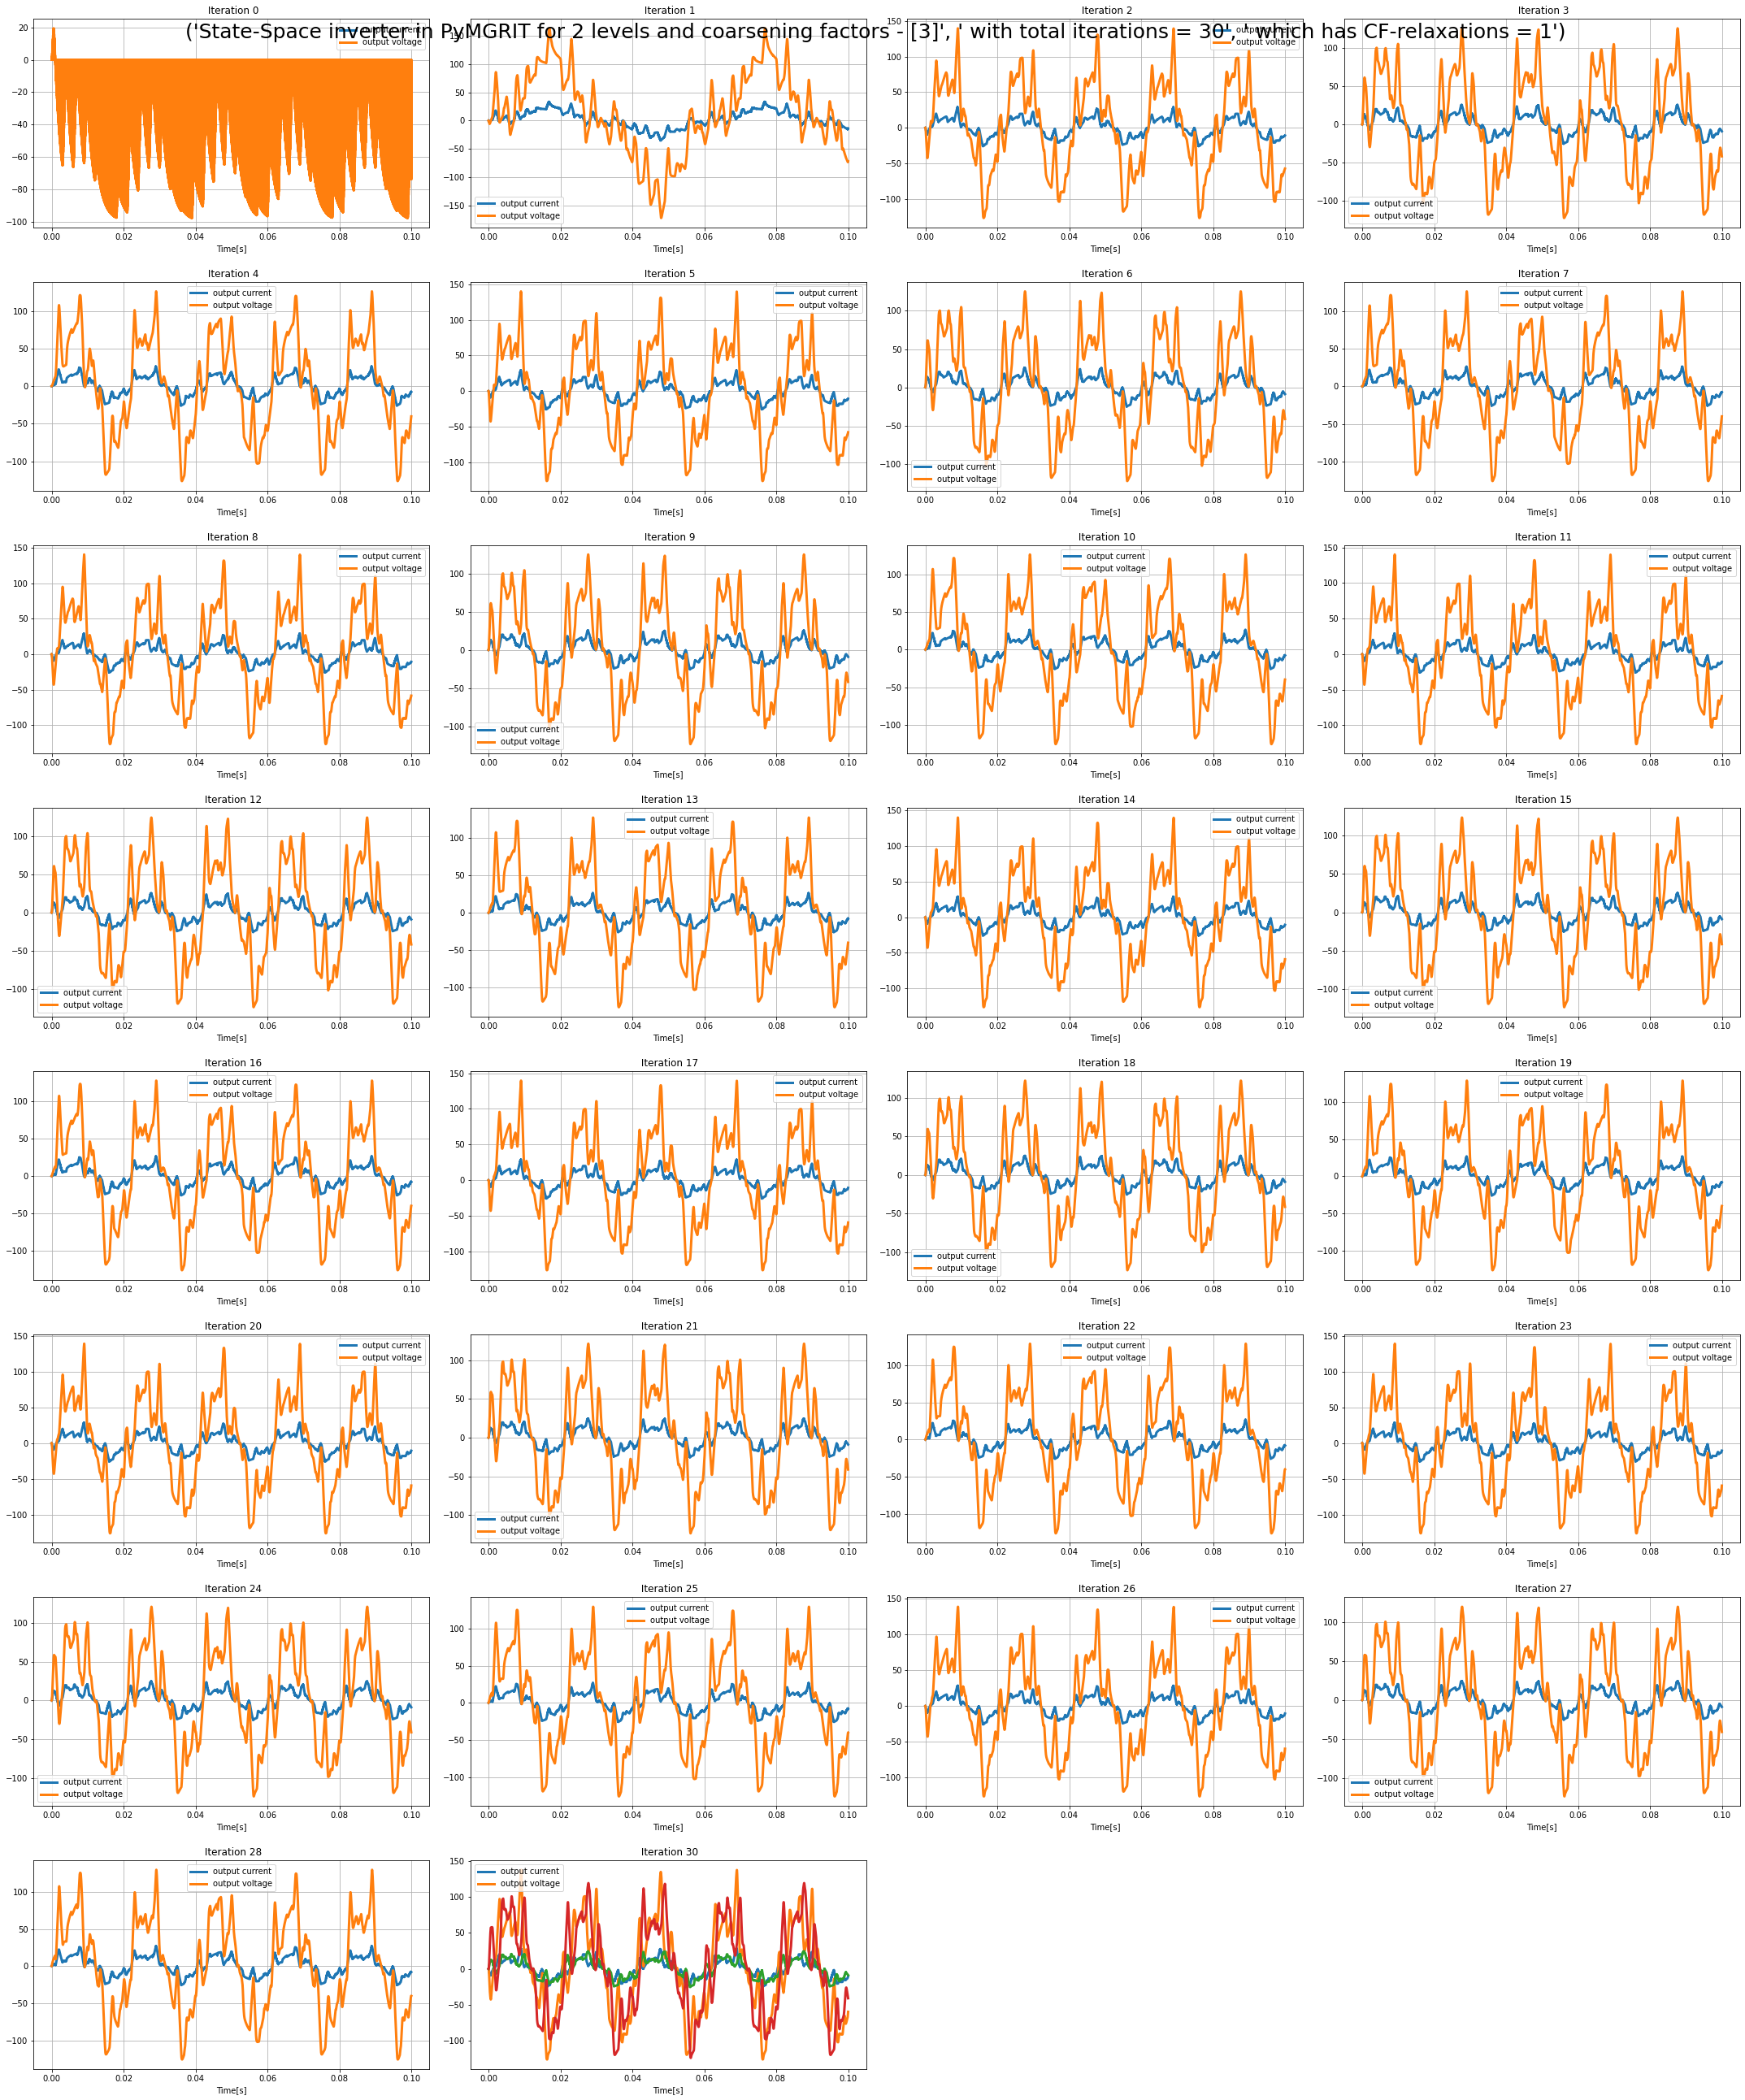

In [57]:
e_val = []
c = 1
fig = plt.figure(1,figsize=(30,45))
title_text = 'State-Space inverter in PyMGRIT for '+ str(2) + ' levels and coarsening factors - '+str([5]), ' with total iterations = '+str(iterations_needed-1),' which has CF-relaxations = '+str(1) 
for i in range(iterations_needed):
    
    #if (i < 20) or (i > 80):         
    e_val = (final_sol[i])
    plt.subplot(10,4,c) 
    #plt.figure(1)
    plt.plot(t, e_val[2,:],t, e_val[3,:],linewidth=3)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=2)
    plt.legend(['output current','output voltage'])
    plt.xlabel('Time[s]')
    plt.grid()
    
    #plt.figure(2)
#     plt.plot(t, e_val[3,:],linewidth=3)
#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=2)
#     plt.legend(['output voltage'])
#     plt.xlabel('Time[s]')
#     plt.grid()
#     plt.legend(['Voltage Node 1','Voltage Node 2'])
#     plt.xlabel('Time[s]')
#     plt.ylabel('Amplitude[V]')
    plt.title(' Iteration '+str(i))
    if c < iterations_needed-1:
        c = c+1

plt.suptitle(title_text,fontsize=25)        
plt.tight_layout(pad=1, w_pad=1, h_pad=2.0)
#plt.savefig('results/StateSpaceInverter/StateSpaceInverter_Model_oddCF '+str(randrange(100)))
plt.show()

C:\Users\ssahi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


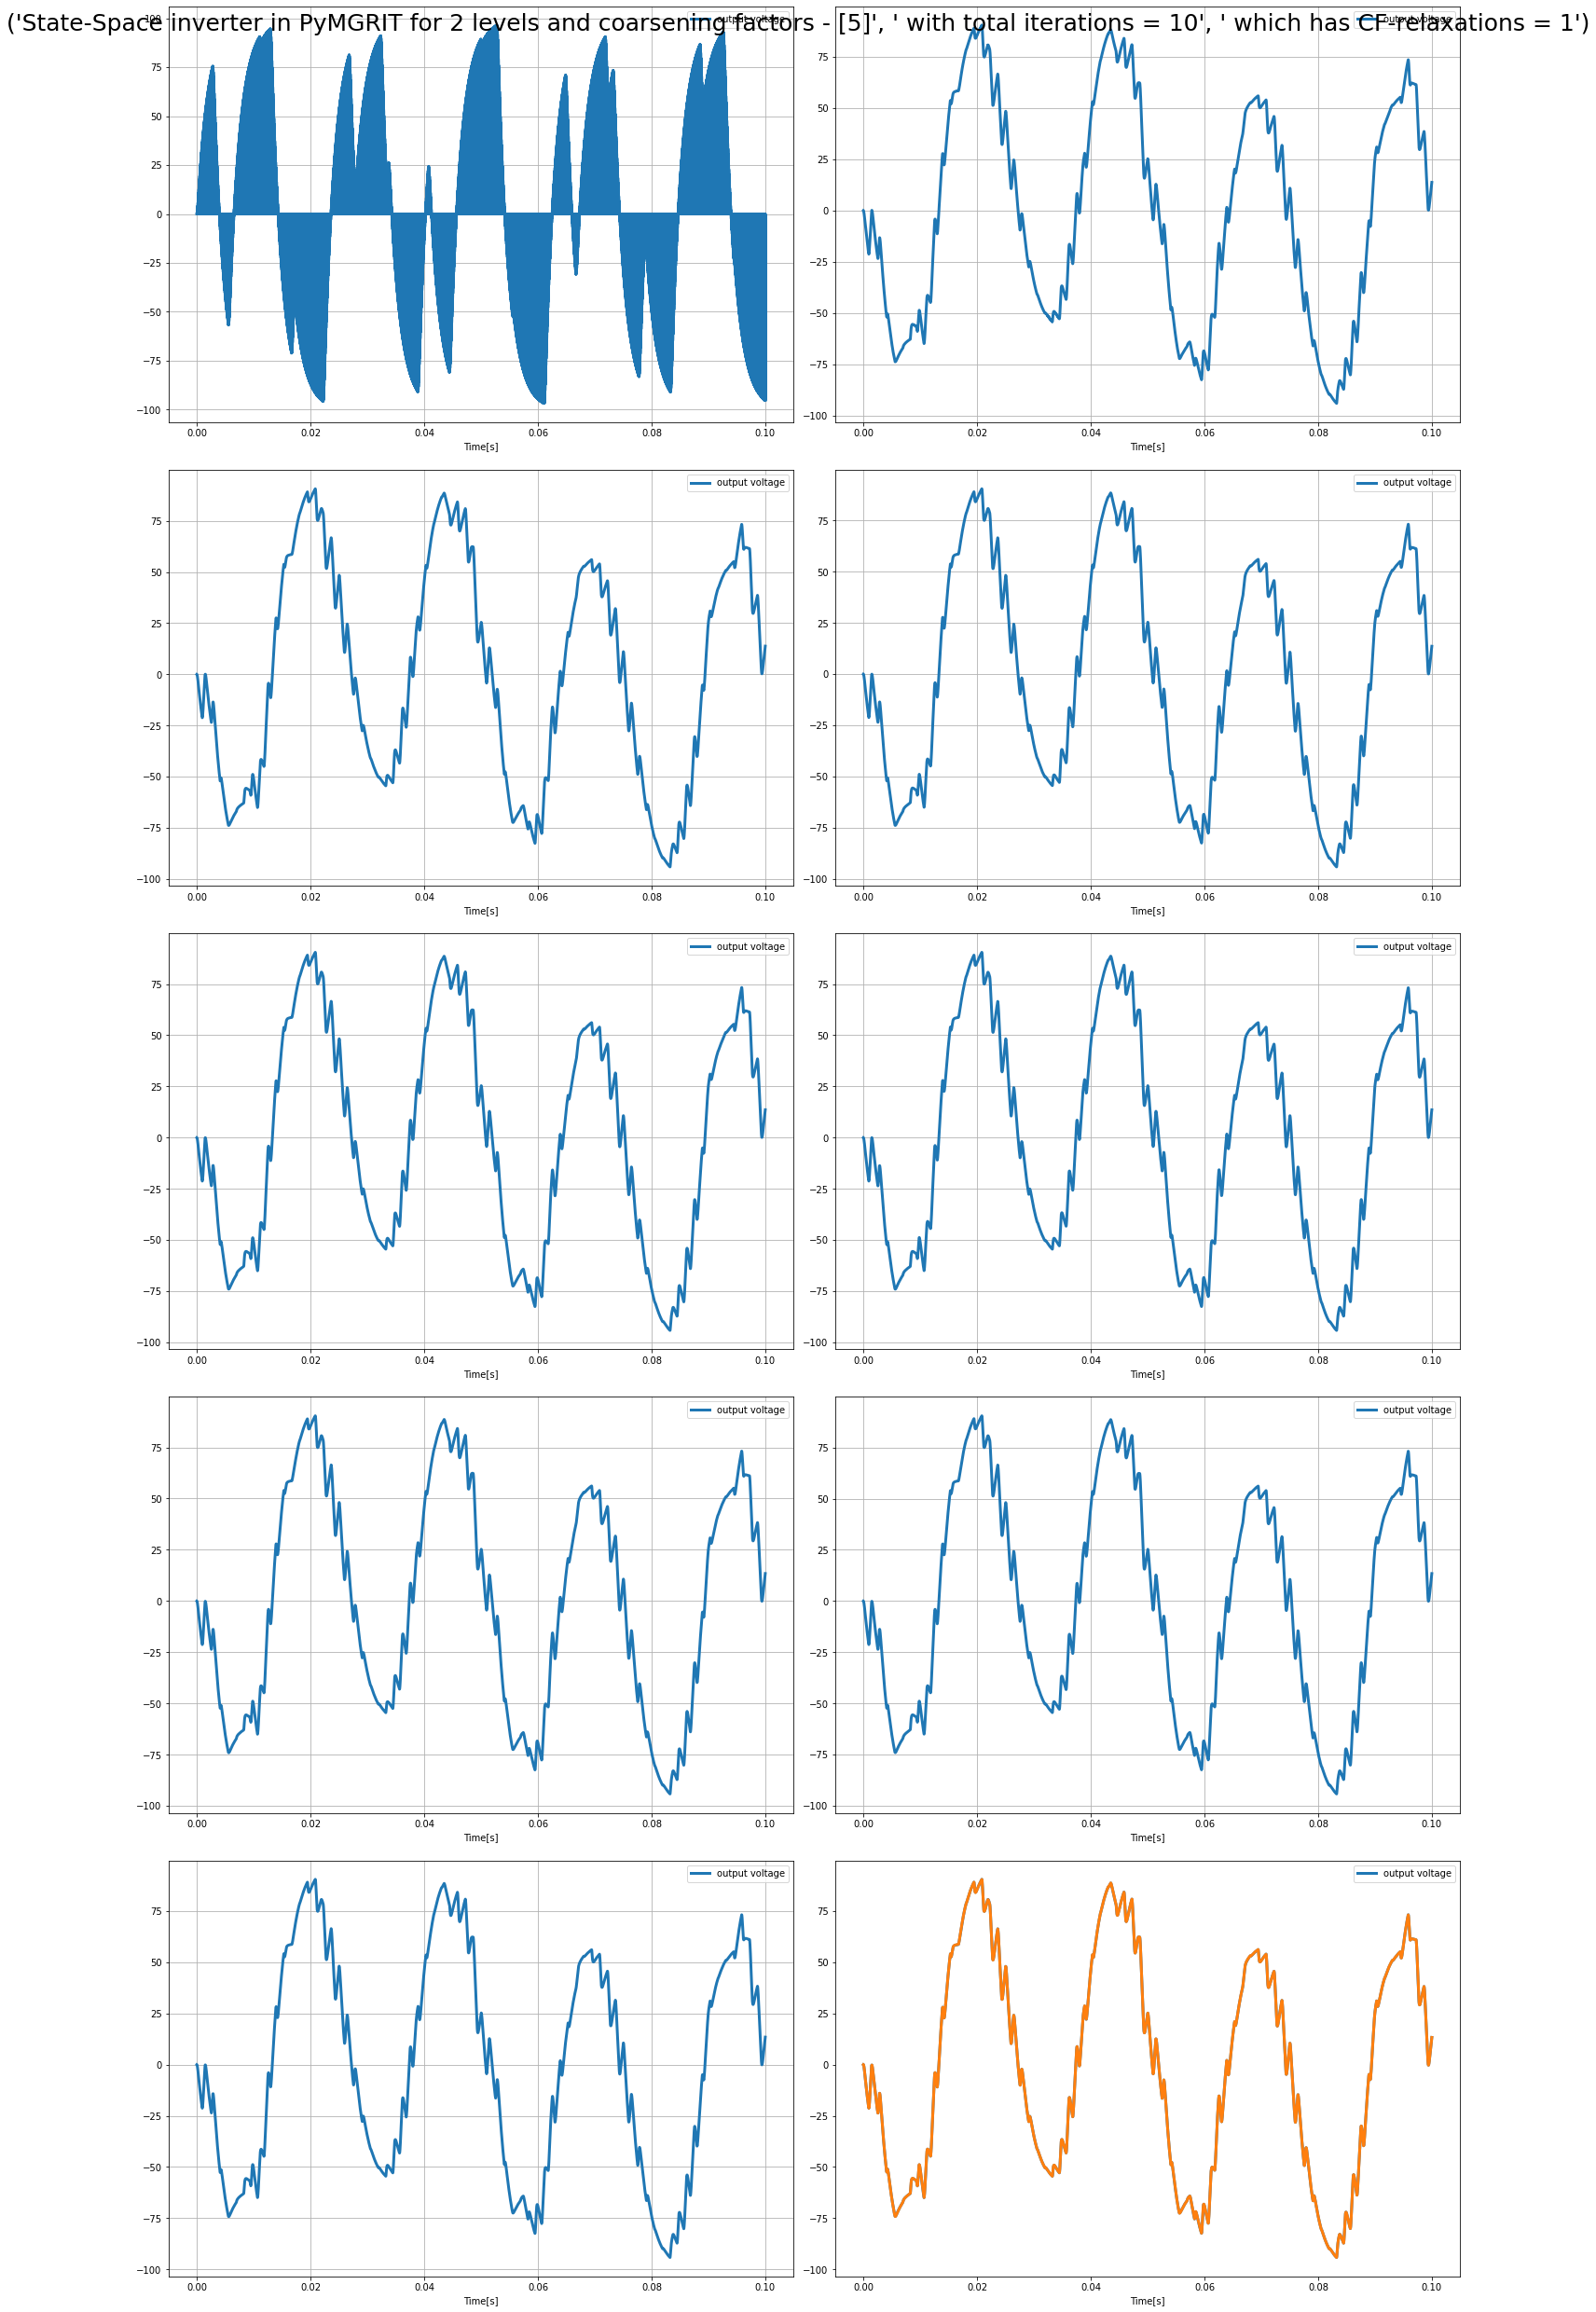

In [21]:
e_val = []
c = 1
fig = plt.figure(1,figsize=(20,35))
title_text = 'State-Space inverter in PyMGRIT for '+ str(2) + ' levels and coarsening factors - '+str([5]), ' with total iterations = '+str(iterations_needed-1),' which has CF-relaxations = '+str(1) 
for i in range(iterations_needed):
    
    #if (i < 20) or (i > 80):         
    e_val = (final_sol[i])
    plt.subplot(5,2,c) 
    #plt.figure(1)
    plt.plot(t, e_val[3,:],linewidth=3)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=2)
    plt.legend(['output voltage'])
    plt.xlabel('Time[s]')
    plt.grid()
    
    #plt.figure(2)
#     plt.plot(t, e_val[3,:],linewidth=3)
#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=2)
#     plt.legend(['output voltage'])
#     plt.xlabel('Time[s]')
#     plt.grid()
#     plt.legend(['Voltage Node 1','Voltage Node 2'])
#     plt.xlabel('Time[s]')
#     plt.ylabel('Amplitude[V]')
    #plt.title('Trapezoidal iteration '+str(i))
    if c < iterations_needed-1:
        c = c+1

plt.suptitle(title_text,fontsize=25)        
plt.tight_layout(pad=1, w_pad=1, h_pad=2.0)
#plt.savefig('results/SubstituteInverter/Trapezoidal_withfalut '+str(randrange(100)))
plt.show()

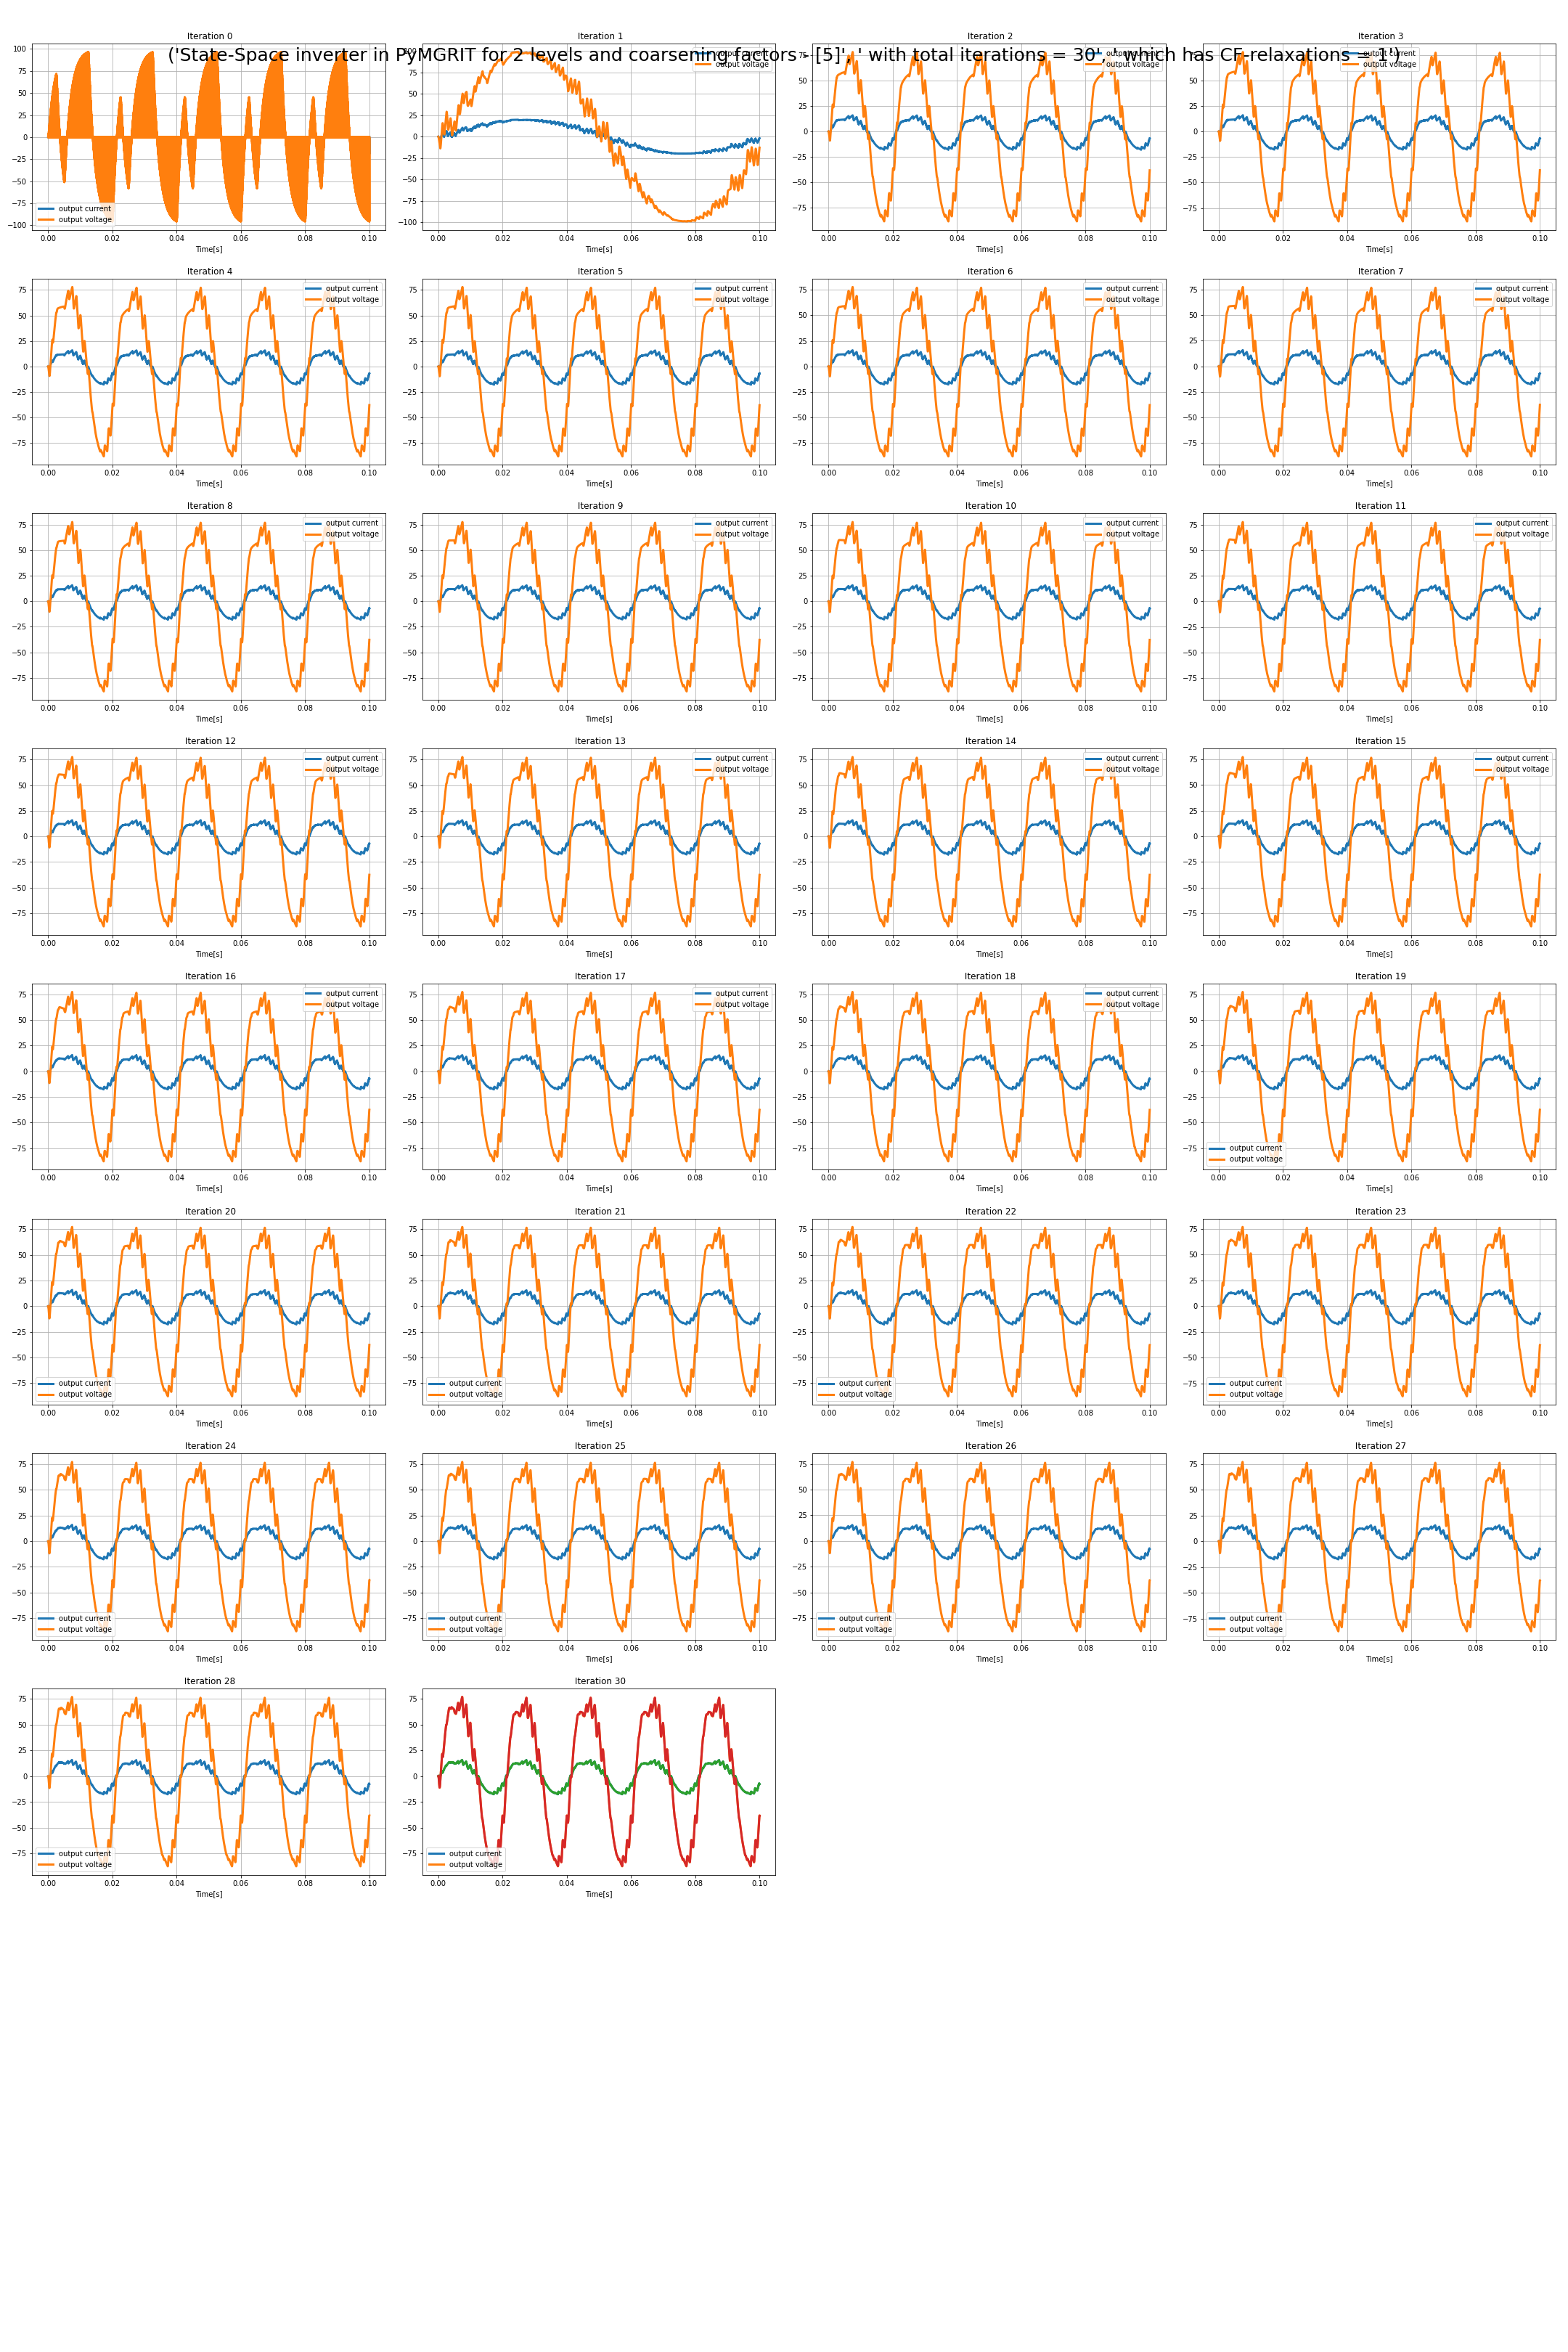

4